<a href="https://colab.research.google.com/github/Sylvariane/categorisation_de_questions/blob/main/P05_02_notebooktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Modelisation

- Configuration

In [1]:
# connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#from nlp_module import remove_stopwords, plot_top_words
import sklearn
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
#sklearn.set_config(display="diagram")

In [4]:
import spacy
import nltk
import re
from bs4 import BeautifulSoup
import unicodedata

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


## 1) Data preparation

In [5]:
path = "/content/drive/My Drive/Ingénieur ML - OC/P5_NLP/datasets/posts_clean.csv"

In [6]:
data = pd.read_csv(path)
print(data.head(3))

       Id  ...                                     Tags
0  415192  ...                   <python><web-services>
1  415344  ...  <debugging><language-agnostic><logging>
2  414981  ...                               <c#><.net>

[3 rows x 4 columns]


In [7]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : " "}, regex=True)

In [8]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [9]:
data.isnull().mean()

Id       0.000000
Title    0.000061
Body     0.000000
Tags     0.000000
dtype: float64

In [10]:
data.dropna(inplace=True)

In [11]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,python web-services
1,415344,log implementation prefer,implement log class c try decide curious know ...,debugging language-agnostic logging
2,414981,directly modify list element,struct struct map public int size public map i...,c# .net


In [12]:
data = data.sample(frac=0.4, random_state=42)

In [13]:
docs = data["Title"] + " " + data["Body"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
# Materialize the sparse data
data_dense = tfidf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.4084176349965824 %


## 2) Topic Modelling

### a) Non Negative Matrix Factorization (NMF)

In [ ]:
best_num_topics = 10

In [ ]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [ ]:
nmf.fit(tfidf)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

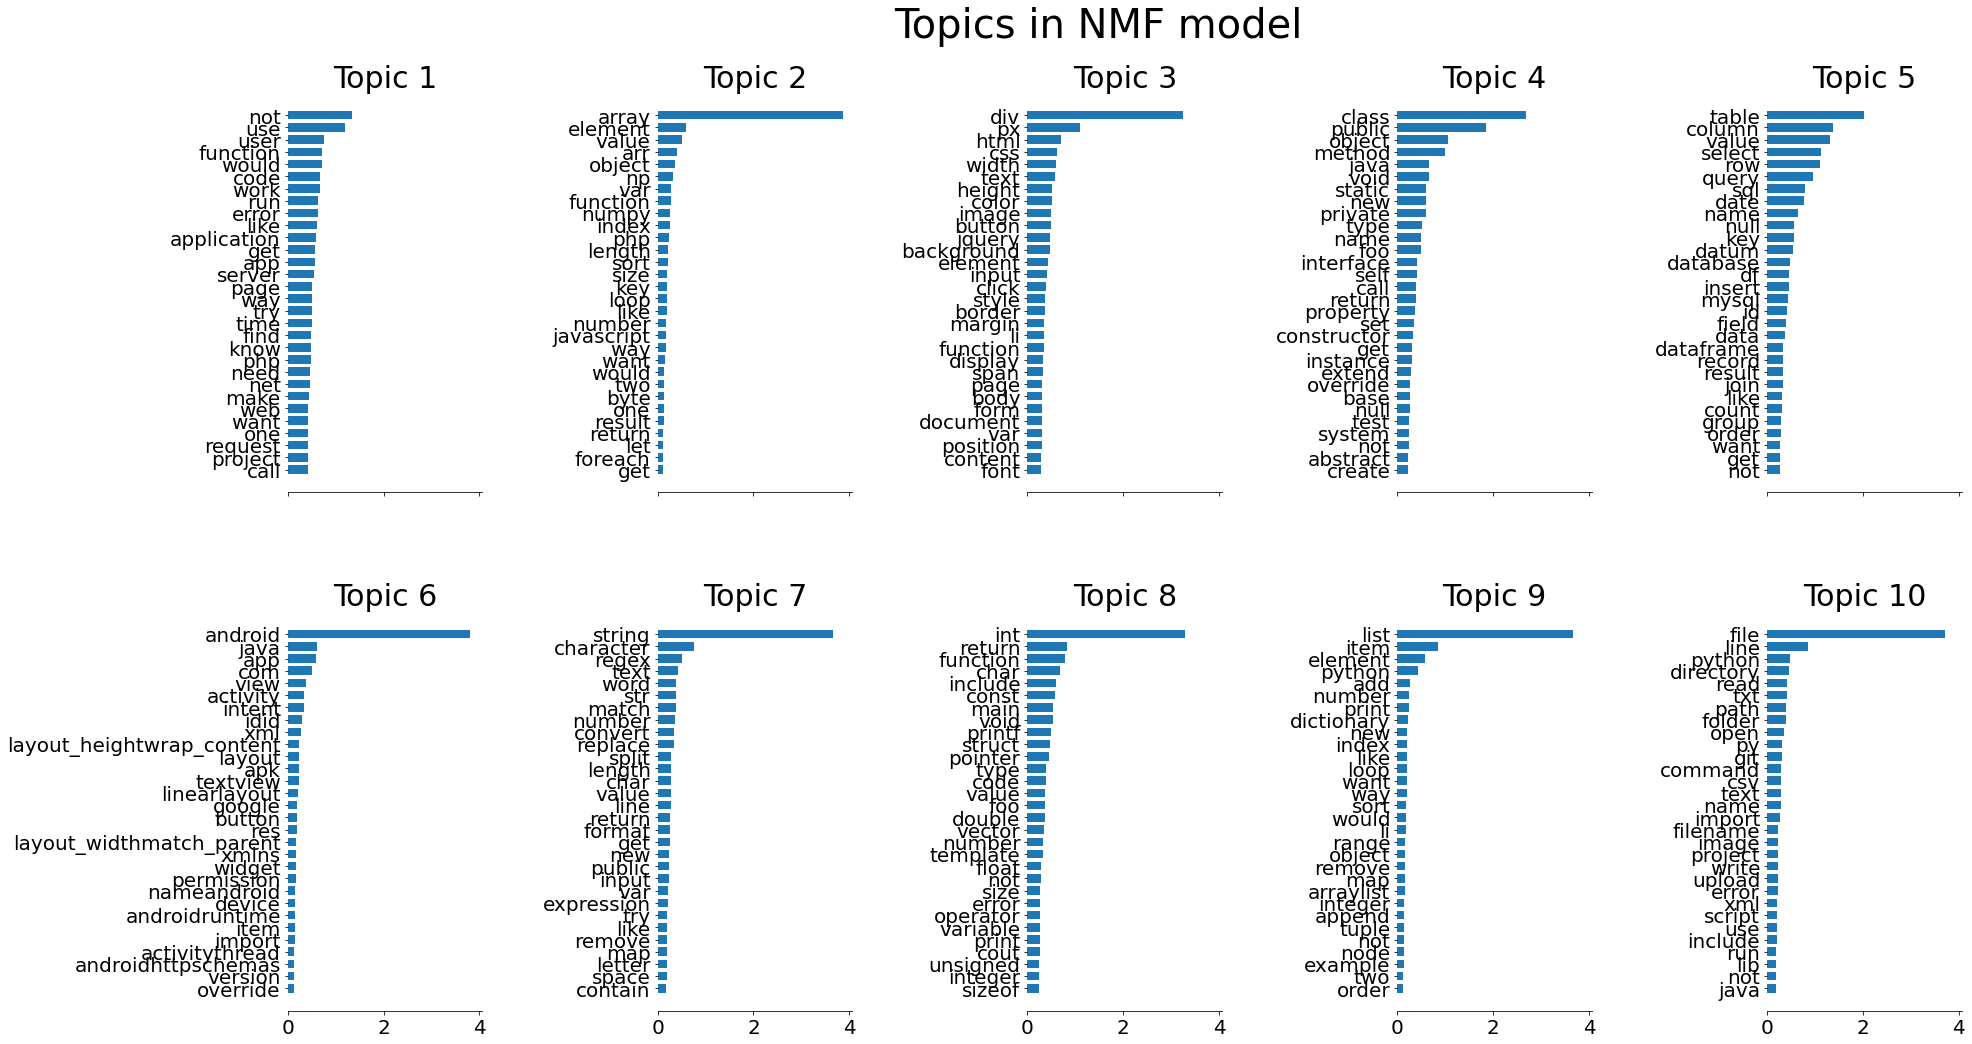

In [ ]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

### b) Latent Dirichlet Allocation (LDA)

In [14]:
def tok(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text)

In [ ]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=tok)
docs_bow = bow_vectorizer.fit_transform(docs)

In [ ]:
lda = LatentDirichletAllocation(random_state=42,
                                n_jobs=-1)

In [ ]:
params = {'n_components' : [8, 9, 10, 11],
          'learning_method' : ["online", "batch"],
          'learning_decay' : [0.6, 0.7, 0.8, 0.9]}


gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5)
gridsearch_lda.fit(docs_bow)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more d

GridSearchCV(cv=5, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=-1,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                                   

In [ ]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 9}
Best Log Likelihood Score:  -598995.3902183331


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      111.092506 -133.722946       1        1  59.296221
6       34.946613  107.064590       2        1   9.043403
0      -28.088213 -159.949036       3        1   7.962233
1      147.698074   21.369604       4        1   6.315229
2      -97.501183  126.981384       5        1   4.370923
8       30.312096  -32.794945       6        1   4.350647
5     -155.443665 -118.494690       7        1   3.989710
3     -204.248108   22.596130       8        1   2.518557
7      -79.404678   -6.864717       9        1   2.153076, topic_info=             Term         Freq        Total Category  logprob  loglift
5229          int  1223.000000  1223.000000  Default  30.0000  30.0000
391       android   729.000000   729.000000  Default  29.0000  29.0000
2905          div   759.000000   759.000000  Default  28.0000  28.0000
4328          git   492.000000   492.000000  Default  27.0000  27.0000
10323       table   773.000000   773.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
9213    semaphore    19.409746    22.034168   Topic9  -5.8784   3.7115
4967      ilogger    15.646192    17.121375   Topic9  -6.0940   3.7482
4561    hashtable    22.222890    31.079785   Topic9  -5.7431   3.5028
3585   extensions    18.938799    24.220294   Topic9  -5.9030   3.5923
10323       table    90.076547   773.397320   Topic9  -4.3435   1.6881

[597 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
147        1  0.101753        activity
147        5  0.895426        activity
154        5  0.938471  activitythread
178        3  0.940807        addclass
298        1  0.299327       algorithm
...      ...       ...             ...
11937      7  0.951262            yarn
11942      1  0.328984            year
11942      4  0.657969            year
11969      1  0.021123            yyyy
11969      4  0.950550            yyyy

[1265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 1, 2, 3, 9, 6, 4, 8])

- Topic 1 : OS - Top topic
- Topic 2 : Script Language/Python
- Topic 3 : Web language/Front-end
- Topic 4 : Java
- Topic 5 : Web language/Back-end
- Topic 6 : SQL
- Topic 7 : Script Language
- Topic 8 : Data Analysis (Python)

## 3) Supervised learning for text classification

- CRF (Conditional Random Fields)
- Données séquentielles

In [15]:
tags = data[["Id", "Tags"]]

In [16]:
tags = tags["Tags"].str.split(expand=True)
tags['Id'] = data["Id"]
tags.columns = ["1st", "2nd", "3rd", "4th", "5th", "Id"]
tags = tags[["Id", "1st", "2nd", "3rd", "4th", "5th"]]
tags.head()

,Id,1st,2nd,3rd,4th,5th
73660,1709216,c,yaml,None,None,None
35316,11233449,javascript,twitter-bootstrap,None,None,None
28719,6376571,c#,None,None,None,None
149862,61548934,java,spring-boot,docker,maven,None
13680,2652816,javascript,None,None,None,None


In [17]:
tags.fillna("",inplace=True)

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

new_tags=pd.DataFrame(mlb.fit_transform(tags[["1st", "2nd", "3rd", "4th", "5th"]].values),
                      columns=mlb.classes_,
                      index=tags["Id"])

In [ ]:
new_tags = new_tags.to_numpy()

In [19]:
from sklearn.model_selection import train_test_split

X = docs
y = new_tags

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

### a) Support Vector Machine

In [20]:
vectorizer = TfidfVectorizer(ngram_range =(1,1),
                            tokenizer=tok,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(random_state=42))
svm_clf.fit(X_train_vec, y_train)

In [ ]:
X_test_vec = vectorizer.transform(X_test)
y_pred = svm_clf.predict(X_test_vec)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, recall_score, roc_auc_score

def print_evaluation_scores(y_test, predicted):
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted')

In [ ]:
print_evaluation_score(y_test, y_pred)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

svm_ovo_clf = OneVsOneClassifier(SVC(random_state=42))
svm_ovo_clf.fit(X_train_vec, y_train)

In [ ]:
y_pred_ovo = svm_ovo_clf.predict(X_test_vec)

In [ ]:
print_evaluation_score(y_test, y_pred_ovo)

- Grid Search CV

In [ ]:
from sklearn.metrics import make_scorer

scorer_multilabel = make_scorer(print_evaluation_score)

In [ ]:
params = {"kernel" : ["linear", "rbf", "poly", "sigmoid"]}

grid_search = GridSearchCV(, 
                           param_grid=params, 
                           scoring=scorer_multilabel,
                           cv=5)
grid_search.fit(X_train_vec, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_params_

### b) Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB(random_state=42)